# Data chunking

## Authors & Contributors
### Authors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)
- Pier Lorenzo Marasco, Ispra (Italy), [@pl-marasco](https://github.com/pl-marasco)

### Contributors
- Anne Fouilloux, University of Oslo (Norway), [@annefou](https://github.com/annefou)



<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> Overview
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>Why do chunking matter?</li>
        <li>How can I read datasets by chunks to optimize memory usage?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about chunking</li>
        <li>Learn about zarr </li>
        <li>Use kerchunk to consolidate chunk metadata and prepare single ensemble datasets for parallel computing</li>
    </ul>
</div>

## Context

When dealing with large data files or collections, it's often impossible to load all the data you want to analyze into a single computer memory at once.  This is a situation where the Pangeo ecosystem can help you a lot. Xarray offers the possibility to work lazily on data __chunks__, which means pieces of an entire dataset.  By taking a data as 'chunk' we can process our data piece by piece on a single computer using local dask cluster, or distributed computing cluster.  How we will process these 'chunks' in a parallel enviroment will be discussed in [dask_introduction](./dask_introduction.ipynb)  The idia of __chunk__  will be explained here.

When we process our data piece by piece, we would like to have our original data or processed result also save in 'chunks'. [Zarr](https://zarr.readthedocs.io/en/stable/) is a major way used in pangeo ecosystem to save our xarray dataset in __chunk__.

[Zarr](https://zarr.readthedocs.io/en/stable/)  is not the only file format which use __chunk__. We will also be using [kerchunk library](https://fsspec.github.io/kerchunk/) in this notebook to build a virtual __chunked__ dataset based on NetCDF, and show how it optimizes the access and analysis of large datasets.

The analysis is very similar to what we have done in previous episodes, however we will use data on a global coverage and not only on a small geographical area (e.g. Lombardia).

### Data

In this episode, we will be using Global Long Term Statistics (1999-2019) products provided by the [Copernicus Global Land Service](https://land.copernicus.eu/global/index.html) and access them through [S3-comptabile storage](https://en.wikipedia.org/wiki/Amazon_S3) ([OpenStack Object Storage "Swift"](https://wiki.openstack.org/wiki/Swift)) with a data catalog we have created and made publicly available.

## Setup

This episode uses the following main Python packages:

- fsspec {cite:ps}`d-fsspec-2018`
- s3fs {cite:ps}`d-s3fs-2016`
- xarray {cite:ps}`d-xarray-hoyer2017` with [`netCDF4`](https://pypi.org/project/h5netcdf/) and [`h5netcdf`](https://pypi.org/project/h5netcdf/) engines
- dask {cite:ps}`d-dask-2016`
- kerchunk {cite:ps}`d-kerchunk-2021`
- geopandas {cite:ps}`d-geopandas-jordahl2020`
- matplotlib {cite:ps}`d-matplotlib-Hunter2007`

Please install these packages if not already available in your Python environment (see [Setup page](https://pangeo-data.github.io/foss4g-2022/before/setup.html)).

### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

## Global LTS

In the previous episode, we used Long Term tastitics time-series for the region of Lombardy e.g. a very small area. Now we would like to use the original dataset that has a global coverage. Let us first open a single file (for January 1999-2019) to understand how much larger the global dataset is.

In [1]:
import fsspec
import s3fs
import xarray as xr

In [2]:
fs = s3fs.S3FileSystem(anon=True,
      client_kwargs={
         'endpoint_url': 'https://object-store.cloud.muni.cz'
      })

As shown in the [Data discovery](./data_discovery.ipynb) chapter, when we have several files to read at once, we need to use Xarray `open_mfdataset` instead of `open_dataset`. It takes a list in input, and not a single element. We can also use `open_mfdataset` with one file as done below.

Using `open_mfdataset` automatically switch from Numpy Arrays to Dask Arrays as the data structure used by Xarray. The same happens when specifying chunks in `open_dataset` as you'll see below.

In [3]:
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-1221_GLOBE_VGT-PROBAV_V3.0.1.nc'

In [4]:
%%time
LTS = xr.open_mfdataset([fs.open(s3path)])
LTS

CPU times: user 584 ms, sys: 71.4 ms, total: 656 ms
Wall time: 2.41 s


<xarray.Dataset>
Dimensions:  (lon: 40320, lat: 15680)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Data variables:
    crs      |S1 ...
    min      (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    max      (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

## What is __chunk__

If you look carefully to `LTS`, each Data Variable is a `dask.array` with a chunsize of `(15680, 40320)`. So basically accessing one data variable would load arrays of dimensions `(15680, 40320)` into the memory.  You can have the information by clicking the icon indicated in the image below

![Dask.array](../figures/datasize.png)

When you open a netCDF file, by default, the chunks correspond to the entire size of the dataset originated to one file. When you need to analyze a considerable number of large files, the memory may not be sufficient anymore. This is where understanding chunking comes into play.



__chunk__ is putting a dataset into small pieces. 

original data set is one piece, 
![Dask.array](../figures/notchunked.png)
and we put them into pieces.  
![Dask.array](../figures/chunked.png)

We put them into pieces so that we can process our data block by block.  

Lets try to 'chunk' our data array LTS.nobs using following command.
We would like to play with small size, so first we selct our data as you've learnd in [xarray_introduction](./xarray_introduction.ipynb)  

In [5]:
test=LTS.nobs.sel(lat=slice(80.,70.),lon=slice(70.,90))
test

<xarray.DataArray 'nobs' (lat: 1121, lon: 2240)>
dask.array<getitem, shape=(1121, 2240), dtype=float32, chunksize=(1121, 2240), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 70.0 70.01 70.02 70.03 ... 89.96 89.97 89.98 89.99
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... 70.03 70.02 70.01 70.0
Attributes:
    standard_name:  normalized_difference_vegetation_index number_of_observat...
    grid_mapping:   crs
    units:          
    valid_range:    [  1 250]
    cell_methods:   area: mean

The test value have dimensions `(1121, 2240)`.  We will chunk it in a dimetion of 600x600 by following command. 

In [6]:
test=test.chunk(600)
test

<xarray.DataArray 'nobs' (lat: 1121, lon: 2240)>
dask.array<rechunk-merge, shape=(1121, 2240), dtype=float32, chunksize=(600, 600), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 70.0 70.01 70.02 70.03 ... 89.96 89.97 89.98 89.99
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... 70.03 70.02 70.01 70.0
Attributes:
    standard_name:  normalized_difference_vegetation_index number_of_observat...
    grid_mapping:   crs
    units:          
    valid_range:    [  1 250]
    cell_methods:   area: mean

As you can see in the above graphics we got 8 __chunk__.  These 8 chunks are noted as (0,0) ..(0,3) (1,0),..(1,3) as you can see in the next visualisation.  

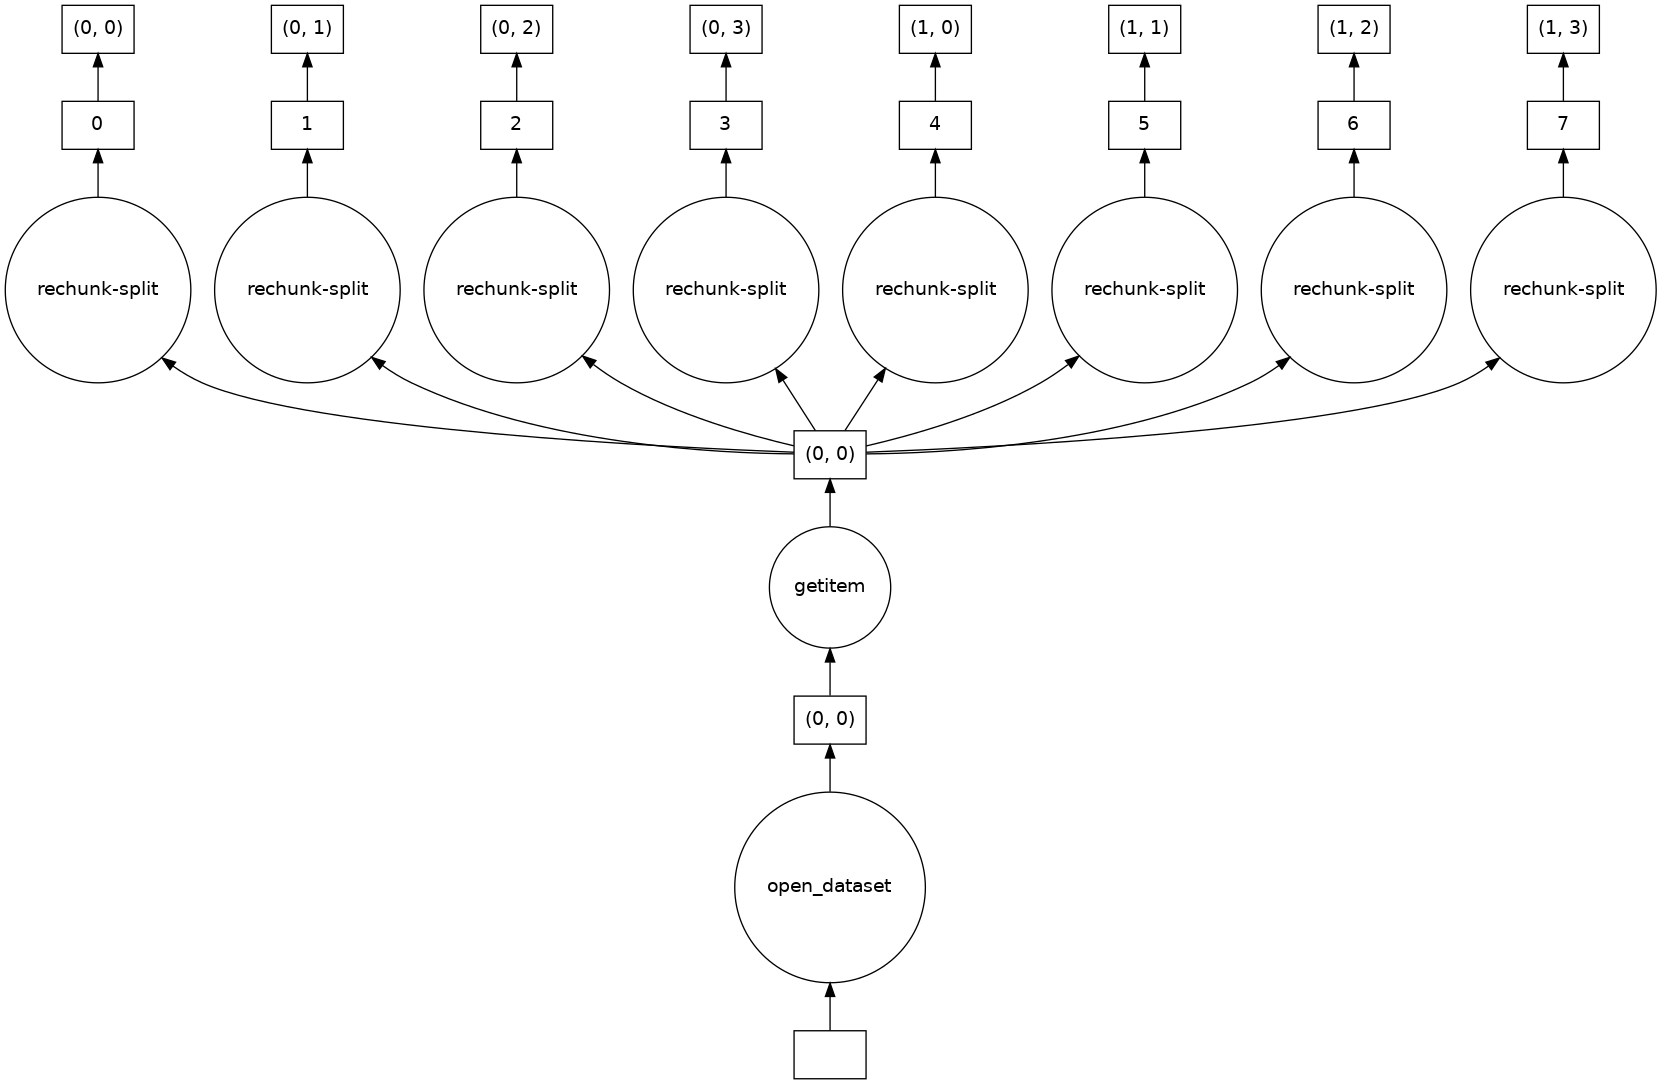

In [7]:
test.data.visualize()

As you can see in the [graphic](../figures/chunkingprocess.png)
When selecting you may have the feeling that the chunk sizes changes. In fact Xarray will still have to fetch the entire initial dataset (LTZ) to perform the selection on any of the Data variables. Again it will not be very optimal (your Python Jupyter kernel may crash too!) with large numbers of files and large files. 
This brings to our next subject [Zarr](https://zarr.readthedocs.io/en/stable/) 
If we can have our oribinal data already 'chunked' we do not need to load entire dataset.  
Lets try to save our test data in a zarr format to learn what zarr is.


In [8]:
test.to_dataset().to_zarr('test.zarr',mode='w')

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Attention</b>
    <br>
    <ul>
        <li>DataArray can not be saved as 'zarr'.  Before saving your data to zarr, you will need to convert that to a DataSet</li>
    </ul>
</div>

<div class="alert alert-info">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Attention</b>
    <br>
    <ul>
        <li>You can try to explore the zarr file you just created using `ls -la test.zarr` and  `ls -la test.zarr/nobs `</li>
        <li>Did you find the __chunks__ you just created in your zarr file? </li>
    </ul>
</div>

In [9]:
!ls -al test.zarr/nobs/

total 48
drwxr-xr-x 2 jovyan jovyan 4096 Aug 16 21:48 .
drwxr-xr-x 5 jovyan jovyan 4096 Aug 16 21:48 ..
-rw-r--r-- 1 jovyan jovyan  341 Aug 16 21:48 .zarray
-rw-r--r-- 1 jovyan jovyan  304 Aug 16 21:48 .zattrs
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 0.0
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 0.1
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 0.2
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 0.3
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 1.0
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 1.1
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 1.2
-rw-r--r-- 1 jovyan jovyan 1482 Aug 16 21:48 1.3


## opening multiple file and Kerchunk

As shown in the [Data discovery](./data_discovery.ipynb) chapter, when we have several files to read at once, we need to use Xarray `open_mfdataset`. When using open_mfdataset for example to NetCDF files, each NetCDF file is automatically considerd as 'one chunk'.  Open_mfdataset analyse each NetCDF files performs multiple operations, like concartenate the coordinate, checking compatibility,..  which is sometime time consuming, and sometime we use exactry same set of input files for different analysis.  [kerchunk library](https://fsspec.github.io/kerchunk/) can build virtual zarr libraries and can load multiple files as a set of 'zarr' file.

But that is not the only optimisation  kerchunk brings to pangeo ecosystem.  



## Exploiting native chunking for reading datasets

Many data formats (for instance,  [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) or [netCDF4](https://unidata.github.io/netcdf4-python/) with HDF5 backend,[geoTIFF](https://en.wikipedia.org/wiki/GeoTIFF)) have chunk cabability.  It is done at the creation of each files.  Lets call that as 'natvie __chunks__'.  These native chunks can be retrieved and used when opening and accessing the files. This will allow significantly reducing the amount of memory when analyzing Data Variables (only the needed chunks will be transferred, and if all the data have to be accessed it can be serializable e.g. chunks are processed one after the other).

 [kerchunk library](https://fsspec.github.io/kerchunk/) can extract these chunk information, and kerchunk can combine group of these information and can create virtual zarr libraries.  

### Extract chunk information

We extract native chunk information from each NetCDF file using `kerchunk.hdf`.
Let's start with a single file.



In [3]:
import kerchunk.hdf

We use `kerchunk.hdf` because our files are written in `netCDF4`  format which is based on HDF5 and `SingleHdf5ToZarr` to translate the metadata of one HDF5 file into Zarr metadata format. The parameter `inline_threshold` is an *optimization* and tells `SingleHdf5ToZarr` to include chunks smaller than this value directly in the output. 

In [4]:
remote_filename = 'https://object-store.cloud.muni.cz/swift/v1/foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-1221_GLOBE_VGT-PROBAV_V3.0.1.nc'
with fsspec.open(remote_filename) as inf:
    h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, remote_filename, inline_threshold=100)
    chunk_info = h5chunks.translate()

Let's have a look at `chunk_info`. It is a Python dictionary so we can use `pprint` to print it nicely.

Content is a bit complicated, but it's only metadata in Zarr format indicating what's in the original file, and where the chunks of the file are located (bytes offset).

In [5]:
from pprint import pprint
pprint(chunk_info)

{'refs': {'.zattrs': '{\n'
                     '    "Conventions": "CF-1.6",\n'
                     '    "archive_facility": "VITO",\n'
                     '    "copyright": "Copernicus Service information 2021",\n'
                     '    "history": "2021-03-01 - Processing line NDVI LTS",\n'
                     '    "identifier": '
                     '"urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1221_GLOBE_V3.0.1",\n'
                     '    "institution": "VITO NV",\n'
                     '    "long_name": "Normalized Difference Vegetation '
                     'Index",\n'
                     '    "orbit_type": "LEO",\n'
                     '    "parent_identifier": '
                     '"urn:cgls:global:ndvi_stats_all",\n'
                     '    "platform": "SPOT-4, SPOT-5, Proba-V",\n'
                     '    "processing_level": "L4",\n'
                     '    "processing_mode": "Offline",\n'
                     '    "product_version": "V3.0.1",\n'
 

After we have collected information on the native chunks in the original data file and consolidated our Zarr metadata, we can open the files using `zarr` and pass this chunk information into a storage option. We also need to pass `"consolidated": False` because the original dataset does not contain any `zarr` consolidating metadata.

In [6]:
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": chunk_info,
        },
        "consolidated": False
    }
)
LTS

<xarray.Dataset>
Dimensions:  (lat: 15680, lon: 40320)
Coordinates:
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    crs      object ...
    max      (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    min      (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

As you can notice above, all the Data Variables are already chunked according to thenative chunking of the NetCDF file.

### Combine all LTS files into one kerchunked single ensemble dataset

Now we will combine all the files into one kerchunked consolidated dataset, and try to open it as a xarray dataset. 

Let us first collect the chunk information for each file.

In [15]:
fs.ls('foss4g-data/CGLS_LTS_1999_2019')

['foss4g-data/CGLS_LTS_1999_2019/',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0111_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0121_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0201_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0211_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0221_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0301_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0311_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0321_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0401_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-

In [7]:
from datetime import datetime

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Attention</b>
    <br>
    <ul>
        <li>check with @pl-marasco: took 5 min using pangeo us infra with 36 files, i propose here just using 3 files.</li>
    </ul>
</div>

In [11]:
%%time
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019/c_gls_*.nc'
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-01*.nc'
chunk_info_list = []
time_list = []

for file in fs.glob(s3path):
    url = 'https://object-store.cloud.muni.cz/swift/v1/' + file
    t = datetime.strptime(file.split('/')[-1].split('_')[3].replace('1999-', ''), "%Y-%m%d")
    time_list.append(t)
    print(file)
    with fsspec.open(url) as inf:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, url, inline_threshold=100)
        chunk_info_list.append(h5chunks.translate())

foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc
foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0111_GLOBE_VGT-PROBAV_V3.0.1.nc
foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0121_GLOBE_VGT-PROBAV_V3.0.1.nc
CPU times: user 1.82 s, sys: 371 ms, total: 2.19 s
Wall time: 27.8 s


This time we use `MultiZarrToZarr` to combine multiple kerchunked datasets into a single logical aggregated dataset. Like when opening multiple files with Xarray `open_mfdataset`, we need to tell `MultiZarrToZarr` how to concatenate all the files. There is no time dimension in the original dataset, but one file corresponds to one date (average over the period 1999-2019 for a given 10-day period e.g. January 01, January 11, January 21, etc.).

In [12]:
%%time
from kerchunk.combine import MultiZarrToZarr
mzz = MultiZarrToZarr(
    chunk_info_list,
    coo_map={'INDEX': 'INDEX'},
    identical_dims=['crs'],
    concat_dims=["INDEX"],
)

out = mzz.translate()

CPU times: user 122 ms, sys: 2.54 ms, total: 124 ms
Wall time: 122 ms


Then, we can open the complete dataset using our consolidated Zarr metadata.

In [13]:
%%time
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": out,
        },
        "consolidated": False
    }
)
LTS

CPU times: user 247 ms, sys: 6.53 ms, total: 253 ms
Wall time: 1.53 s


,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We can save the consolidated metadata for our dataset in a file, and reuse it later to access the dataset.

In [14]:
import json

In [15]:
jsonfile='c_gls_NDVI-LTS_1999-2019.json'
with open(jsonfile, mode='w') as f :
    json.dump(out, f)

We can then load data from this catalog.

In [16]:
import xarray as xr
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":'./c_gls_NDVI-LTS_1999-2019.json',
        },
        "consolidated": False
    }
)
LTS

,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Attention</b>
    <br>
    <ul>
        <li>check with @pl-marasco: below may be better to move on dask intro? </li>
    </ul>
</div>

We can also postprocess LTS to get the dates properly set.

In [17]:
LTS = LTS.rename({'INDEX': 'time'}).assign_coords(time=time_list)
LTS

,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [ ]:
import geopandas as gpd

In [ ]:
try:
    GAUL = gpd.read_file('Italy.geojson')
except:
    GAUL = gpd.read_file('zip+https://mars.jrc.ec.europa.eu/asap/files/gaul1_asap.zip') 

In [ ]:
AOI_name = 'Lombardia'
AOI = GAUL[GAUL.name1 == AOI_name]
AOI_poly = AOI.geometry
AOI_poly

In [ ]:
LTS = LTS.sel(lat=slice(46.5,44.5), lon=slice(8.5,11.5))
LTS = LTS.rio.write_crs(4326)

In [ ]:
LTS = LTS.rio.clip(AOI_poly, crs=4326)

In [ ]:
LTS

In [ ]:
%%time
LTS.compute()

## Visualize LTS statistics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(1, figsize=[15,5])

# Fix extent
minval = 0.0
maxval = 0.9

itime=0 # plot the first date

# Plot 1 for min subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1)
LTS.isel(time=itime)['min'].plot(ax=ax1)
# Plot 2 for max
# 2nd plot 
ax2 = plt.subplot(1, 2, 2)
LTS.isel(time=itime)['max'].plot(ax=ax2)

# Title for both plots
fig.suptitle('LTS NDVI statistics (Minimum and Maximum)', fontsize=20)

The catalog (json file we created) can be shared on the cloud (or github, etc.) and anyone can load it from there too.
This approach allows anyone to easily access LTS data and select the Area of Interest for their own study.

## Conclusion

Understanding chunking is key to optimize your data analysis. In this episode we learned how to optimize the memory by exploiting native chunks from netCDF4 data files and instructing Xarray to access data per chunk. However, computations can be very slow and to optimize the computational part we need to parallelize our data analysis. This is what you will learn in the next episode with Dask.

<div class="alert alert-success">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Key Points</b>
    <br>
    <ul>
        <li>Chunking </li>
        <li>zarr </li>
        <li>kerchunk</li>
    </ul>
</div>

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "chunking" and topic % "package"
:keyprefix: d-
```